In [51]:
%load_ext autoreload
%autoreload 2

import torch.optim as optim
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import tqdm
from random import seed
from random import randint
from models import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# from google.colab import drive
# drive.mount('/content/drive')
# root_dir = "/content/drive/MyDrive/dissertation data/"
root_dir = "./"

In [54]:
EPOCHS=3
Batch_Size=25
lr=1e-4
beta1=0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed(1)
print(device)



cpu


In [55]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [56]:
img_size = (64,64)
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.CenterCrop(128),
                                transforms.Resize(img_size,transforms.InterpolationMode.BILINEAR),
                                # transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])
class MRIDataset(Dataset):
    """MRI dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filenames = os.listdir(root_dir)
        if ".DS_Store" in self.filenames:
            self.filenames.remove(".DS_Store")
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # print(repr(idx))
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.filenames[idx],f"sub-{self.filenames[idx]}_ses-NFB3_T1w.nii.gz")
        # random between 40 and 130
        # print(nib.load(img_name).slicer[:,90:91,:].dataobj.shape)
        sliceIdx = randint(40, 130)
        # sliceIdx = 90
        img = nib.load(img_name)
        image = img.get_fdata()

        image_mean = np.mean(image)
        image_std = np.std(image)
        img_range = (image_mean - 1 * image_std, image_mean + 2 * image_std)
        image = np.clip(image,img_range[0],img_range[1])
        image = image / (img_range[1]-img_range[0])
        image = image[:,sliceIdx:sliceIdx+1,:].reshape(256,192).astype(np.float32)

        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image,"filenames":self.filenames[idx]}
        return sample

torch.Size([25, 1, 64, 64])


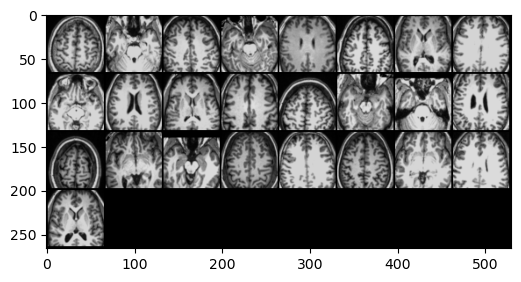

In [57]:
training_dataset = MRIDataset(root_dir=f'{root_dir}Train/',transform=transform)
testing_dataset = MRIDataset(root_dir=f'{root_dir}Test/',transform=transform)
# testing_dataset = MRIDataset(root_dir='/content/drive/MyDrive/dissertation data/Anomalous/',transform=transform)
dataset_loader = cycle(torch.utils.data.DataLoader(training_dataset,
                                             batch_size=Batch_Size, shuffle=True,
                                             num_workers=2))
                                            # num_workers=1))
new = next(dataset_loader)

# new["image"] = torch.cat((new["image"][:],new["image"][:],new["image"][:]),dim=1)
print(new["image"].shape)
plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(new["image"] / 2. + 0.5).cpu().data.permute(0, 2, 1).contiguous().permute(2, 1, 0),
            cmap='gray')
plt.show()
plt.pause(0.0001)


In [58]:
# try:
#     os.makedirs("result/train/cropped")
#     os.makedirs("result/train/real")
#     os.makedirs("result/train/recon")
#     os.makedirs("model")
# except OSError:
#     pass
    

In [59]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [60]:
        # base_channels,
        # channel_mults=(1,2,4,8),
        # res_block_layer_count=2,
        # activation=F.relu,
        # dropout=0.1,
        # attention_resolutions=(None,32,16,8),
        # num_groups=32
unet = UNet(128,channel_mults=(1,2,3,4),dropout=0.1,attention_resolutions=(None,32,16,8))
unet.apply(weights_init)

betas = get_beta_schedule(1000,"cosine")

diffusion = GaussianDiffusion(unet.to(device),img_size,betas)
diffusion.apply(weights_init)

# diffusion.load_state_dict(torch.load(f'{root_dir}diff-params-24-11-100epochs',map_location=device))

diffusion = diffusion.to(device)



optimiser = optim.Adam(diffusion.parameters(), lr=lr, betas=(beta1, 0.999))


In [61]:

tqdm_epoch = tqdm.notebook.trange(EPOCHS)
  # dataset loop
for epoch in tqdm_epoch:
  
    for i in range(100//Batch_Size):
        data = next(dataset_loader)
        x = data["image"]
        x = x.to(device)
        loss,noisy,est = diffusion(x)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()


        tqdm_epoch.set_postfix({"imgs trained":(1+i)*Batch_Size+epoch*100,"loss":loss.data})
        if epoch%5==0 and i==0:
            rowSize=8
            # if epoch%20==0:
            #   sample = diffusion.forward_backward(x,0.2,False)
            #   out = torch.cat((x[:rowSize,...].cpu(),sample[:rowSize,...]))
            # else:
            out = torch.cat((x[:rowSize,...].cpu(),noisy[:rowSize,...].cpu(),est[:rowSize,...].cpu()))

            plt.rcParams['figure.dpi'] = 150
            plt.grid(False)
            plt.imshow(torchvision.utils.make_grid(out / 2. + 0.5,nrow=rowSize).cpu().data.permute(0, 2, 1).contiguous().permute(2, 1, 0),
                      cmap='gray')

            plt.show()
            plt.pause(0.0001)


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
testing_dataset_loader = cycle(torch.utils.data.DataLoader(testing_dataset,
                                             batch_size=Batch_Size, shuffle=True,
                                             num_workers=2))
plt.rcParams['figure.dpi'] = 200
for i in range(3):
  data = next(dataset_loader)
  x = data["image"]
  x = x.to(device)
  rowSize=5
  fig,ax = plt.subplots()
  out = diffusion.forward_backward(x,True)
  imgs = [[ax.imshow(torchvision.utils.make_grid(x / 2. + 0.5,nrow=rowSize).cpu().data.permute(0, 2, 1).contiguous().permute(2, 1, 0),animated=True)] for x in out]
  # out = out.permute(0,2,3,1)
  ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True,
                                repeat_delay=1000)

  ani.save(f'/content/drive/MyDrive/dissertation data/dynamic_images{i}.mp4')
  print("saved")
  plt.grid(False)
  plt.imshow(torchvision.utils.make_grid(out[-1] / 2. + 0.5,nrow=rowSize).cpu().data.permute(0, 2, 1).contiguous().permute(2, 1, 0),
             cmap='gray')

  plt.show()
  plt.pause(0.0001)
  

In [ ]:
# torch.save(diffusion.state_dict(),f'/content/drive/MyDrive/dissertation data/diff-params-24-11-100epochs')